In [1]:
!pip install pyamg
import pyamg
import sys
import cv2
import time
import glob
import scipy.sparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image 
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd.variable import Variable
from torchvision import datasets, transforms

     |████████████████████████████████| 6.4 MB 5.6 MB/s 


In [2]:
print(sys.version)
device='cuda'

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
CUDA is available!  Training on GPU ...


In [3]:
def gen_mask(sample_batch, img_size, mask_type):
    np.random.seed(seed=int(time.time())) 
    masks = np.ones((sample_batch, img_size, img_size), dtype=np.float32)

    if mask_type == 'center':
        scale = 0.25
        low, upper = int(img_size * scale), int(img_size * (1.0 - scale))
        masks[:, low:upper, low:upper] = 0.
    elif mask_type == 'random':
        ratio = 0.8
        masks[np.random.random((sample_batch, img_size, img_size)) <= ratio] = 0.
    elif mask_type == 'half':
        half_types = np.random.randint(4, size=sample_batch)
        masks = [half_mask(half_types[idx], img_size) for idx in range(sample_batch)]
        masks = np.asarray(masks)
    elif mask_type == 'pattern':
        masks = [pattern_mask(img_size) for _ in range(sample_batch)]
        masks = np.asarray(masks)
    else:
        raise NotImplementedError

    return masks


def half_mask(half_type, img_size):
    mask = np.ones((img_size, img_size), dtype=np.float32)
    half = int(img_size / 2.)

    if half_type == 0:  # top mask
        mask[:half, :] = 0.
    elif half_type == 1:  # bottom mask
        mask[half:, :] = 0.
    elif half_type == 2:  # left mask
        mask[:, :half] = 0.
    elif half_type == 3:  # right mask
        mask[:, half:] = 0.
    else:
        raise NotImplementedError

    return mask


def pattern_mask(img_size):
    num_points, ratio = 3, 0.25
    mask = np.zeros((img_size, img_size), dtype=np.float32)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

    for num in range(num_points):
        coordinate = np.random.randint(img_size, size=2)
        mask[coordinate[0], coordinate[1]] = 1.
        mask = cv2.dilate(mask, kernel, iterations=1)

    while np.sum(mask) < ratio * img_size * img_size:
        flag = True
        while flag:
            coordinate = np.random.randint(img_size, size=2)
            if mask[coordinate[0], coordinate[1]] == 1.:
                mask2 = np.zeros((img_size, img_size), dtype=np.float32)
                mask2[coordinate[0], coordinate[1]] = 1.
                mask2 = cv2.dilate(mask2, kernel, iterations=1)

                mask[mask + mask2 >= 1.] = 1.
                flag = False

    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return 1. - mask

In [4]:
def rescale(image,image_size):
  rescaled = np.resize(image,(image_size,image_size))
  return torch.from_numpy(rescaled)

In [5]:
folder_data = glob.glob("../input/celeba-dataset/img_align_celeba/img_align_celeba/*.jpg")
len_data = len(folder_data)
print(len_data)

test_image_paths = folder_data[200000:200512]


class TestDataset(Dataset):
  def __init__(self, image_paths, mask_type, mask_generator, scale):
    self.image_paths = image_paths
    self.mask_type = mask_type
    self.transforms = transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
    self.mask_generator = mask_generator
    self.scale = scale

  def __getitem__(self, index):
    image = Image.open(self.image_paths[index])
    mask = self.mask_generator(1,64,self.mask_type)
    t_image = self.transforms(image)
    t_mask = self.scale(mask,64)
    return t_image,t_mask

  def __len__(self):
    return len(self.image_paths)

202599


In [6]:
test_dataset_center = TestDataset(test_image_paths,mask_type='center',mask_generator=gen_mask,scale=rescale)
test_dataset_pattern = TestDataset(test_image_paths,mask_type='pattern',mask_generator=gen_mask,scale=rescale)
test_loader_center = torch.utils.data.DataLoader(test_dataset_center, batch_size=16, shuffle=False)
test_loader_pattern = torch.utils.data.DataLoader(test_dataset_pattern, batch_size=16, shuffle=False)
print(len(test_dataset_center))
print(len(test_loader_center))

512
32


In [7]:
def get_weights(masks,window_size):

  assert (window_size+1)%2 == 0

  pad_value = (window_size-1)/2
  padded_masks = F.pad(1-masks, (int(pad_value),int(pad_value),int(pad_value),int(pad_value)), "constant", 0)
  padded_masks.unsqueeze_(1)
  kernel = torch.ones((window_size,window_size))
  kernel = kernel.view(1, 1, window_size, window_size)
  kernel = kernel.to(device)
  temp = F.conv2d(padded_masks,kernel)
  temp.squeeze_(1)
  weights = (1/window_size)*torch.mul(temp,masks)
  return weights

def context_loss(outputs,images,masks,window_size):
  batch_size = images.size()[0]
  W = get_weights(masks,window_size)
  W.unsqueeze_(1)
  W = torch.cat((W,W,W),dim=1)
  closs = (1/batch_size)*(torch.sum(torch.abs(torch.mul(outputs-images,W))))
  return closs

def prior_loss(discriminator_outputs,Lambda):
  batch_size = discriminator_outputs.size()[0]
  ploss = (1/batch_size)*(Lambda*torch.sum(-torch.log(discriminator_outputs)))
  return ploss

def random_z(batch_size):
  Z = torch.randn((batch_size,100,1,1), requires_grad=True,device="cuda")
  return Z

In [8]:
def prepare_mask(mask):
    if type(mask[0][0]) is np.ndarray:
        result = np.ndarray((mask.shape[0], mask.shape[1]), dtype=np.uint8)
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if sum(mask[i][j]) > 0:
                    result[i][j] = 1
                else:
                    result[i][j] = 0
        mask = result
    return mask



def blend(img_target, img_source, img_mask, offset=(0, 0)):
    # compute regions to be blended
    region_source = (
            max(-offset[0], 0),
            max(-offset[1], 0),
            min(img_target.shape[0]-offset[0], img_source.shape[0]),
            min(img_target.shape[1]-offset[1], img_source.shape[1]))
    region_target = (
            max(offset[0], 0),
            max(offset[1], 0),
            min(img_target.shape[0], img_source.shape[0]+offset[0]),
            min(img_target.shape[1], img_source.shape[1]+offset[1]))
    region_size = (region_source[2]-region_source[0], region_source[3]-region_source[1])

    # clip and normalize mask image
    img_mask = img_mask[region_source[0]:region_source[2], region_source[1]:region_source[3]]
    img_mask = prepare_mask(img_mask)
    img_mask[img_mask==0] = False
    img_mask[img_mask!=False] = True

    # create coefficient matrix
    A = scipy.sparse.identity(np.prod(region_size), format='lil')
    for y in range(region_size[0]):
        for x in range(region_size[1]):
            if img_mask[y,x]:
                index = x+y*region_size[1]
                A[index, index] = 4
                if index+1 < np.prod(region_size):
                    A[index, index+1] = -1
                if index-1 >= 0:
                    A[index, index-1] = -1
                if index+region_size[1] < np.prod(region_size):
                    A[index, index+region_size[1]] = -1
                if index-region_size[1] >= 0:
                    A[index, index-region_size[1]] = -1
    A = A.tocsr()
    
    # create poisson matrix for b
    P = pyamg.gallery.poisson(img_mask.shape)

    # for each layer (ex. RGB)
    for num_layer in range(img_target.shape[2]):
        # get subimages
        t = img_target[region_target[0]:region_target[2],region_target[1]:region_target[3],num_layer]
        s = img_source[region_source[0]:region_source[2], region_source[1]:region_source[3],num_layer]
        t = t.flatten()
        s = s.flatten()

        # create b
        b = P * s
        for y in range(region_size[0]):
            for x in range(region_size[1]):
                if not img_mask[y,x]:
                    index = x+y*region_size[1]
                    b[index] = t[index]

        # solve Ax = b
        x = pyamg.solve(A,b,verb=False,tol=1e-10)

        # assign x to target image
        x = np.reshape(x, region_size)
        x[x>255] = 255
        x[x<0] = 0
        x = np.array(x, img_target.dtype)
        img_target[region_target[0]:region_target[2],region_target[1]:region_target[3],num_layer] = x

    return img_target

In [9]:
class GeneratorNet(torch.nn.Module):
  def __init__(self):
    super(GeneratorNet, self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(100, 1024, kernel_size = 4, stride = 1, padding = 0, bias = False),
        nn.BatchNorm2d(1024),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(1024, 512, kernel_size = 4, stride = 2, padding = 1, bias =False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(128, 3, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.Tanh()
    )
    

  def forward(self, x):
    #print(x)
    x = self.main(x)
    #print(x.shape)
    return x

In [10]:
class DiscriminatorNet(torch.nn.Module):
  def __init__(self):
    super(DiscriminatorNet, self).__init__()
    self.main = nn.Sequential(
      nn.Conv2d(3, 128, kernel_size = 5, stride = 2, padding = 2, bias = False),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(128, 256, kernel_size = 5, stride = 2, padding = 2, bias = False),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(256, 512, kernel_size = 5, stride = 2, padding =2, bias = False),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(512, 1024, kernel_size = 5, stride = 2, padding = 2, bias = False),
      nn.BatchNorm2d(1024),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(1024, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
      nn.Sigmoid()
    )
    
  def forward(self, x):
    x = self.main(x)
    return x

In [11]:
Generator = GeneratorNet()
Generator.load_state_dict(torch.load("../input/pretrained-gan-pytorch/g_epoch-30.pth"))
Generator = Generator.to(device)
Generator.eval()
for param in Generator.parameters():
  param.requires_grad = False

Discriminator = DiscriminatorNet()
Discriminator.load_state_dict(torch.load("../input/pretrained-gan-pytorch/d_epoch-30.pth"))
Discriminator = Discriminator.to(device)
Discriminator.eval()
for param in Discriminator.parameters():
  param.requires_grad = False

Starting Training for Batch 1...
Iteration No. = 500
Loss = tensor(661.4401, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1000
Loss = tensor(520.7182, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1500
Loss = tensor(433.6513, device='cuda:0', grad_fn=<AddBackward0>)


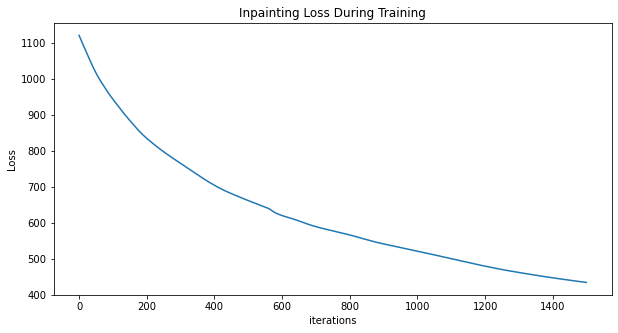

Starting Training for Batch 10...
Iteration No. = 500
Loss = tensor(614.1816, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1000
Loss = tensor(500.2957, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1500
Loss = tensor(436.2889, device='cuda:0', grad_fn=<AddBackward0>)


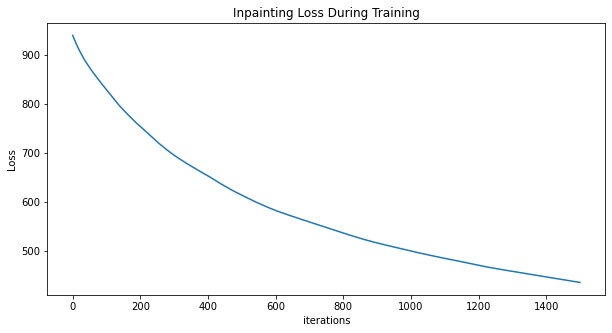

Starting Training for Batch 20...
Iteration No. = 500
Loss = tensor(623.1761, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1000
Loss = tensor(519.2313, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1500
Loss = tensor(453.6305, device='cuda:0', grad_fn=<AddBackward0>)


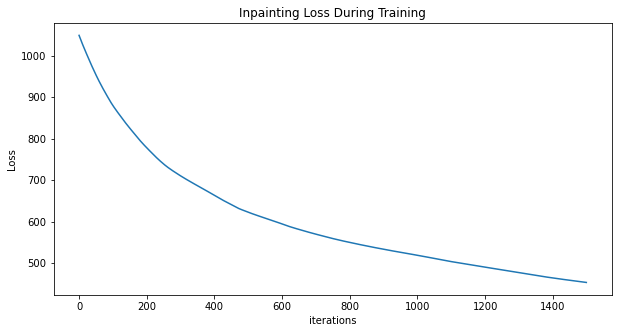

Starting Training for Batch 30...
Iteration No. = 500
Loss = tensor(601.2141, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1000
Loss = tensor(476.1050, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1500
Loss = tensor(411.9230, device='cuda:0', grad_fn=<AddBackward0>)


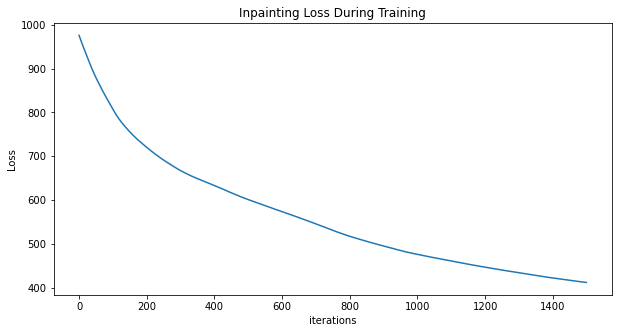

In [12]:
for i, (images, masks) in enumerate(test_loader_center):
  losses = []
  images = images.to(device)
  masks = masks.to(device)
  Z = random_z(batch_size=16)
  optimizer = optim.Adam([Z])
  if (i+1)%10==0 or i==0:
    print("Starting Training for Batch "+str(i+1)+"...")
  for iter in range(1500):
    outputs = Generator(Z)
    discriminator_outputs = Discriminator(outputs)
    closs = context_loss(outputs,images,masks,window_size=7)
    ploss = prior_loss(discriminator_outputs,Lambda=0.003)
    inpainting_loss = closs + ploss
    optimizer.zero_grad()
    inpainting_loss.backward()
    optimizer.step()
    losses.append(inpainting_loss)
    if (i+1)%10==0 or i==0:
      if (iter+1)%500==0:
        print("Iteration No. = "+str(iter+1))
        print("Loss = "+str(inpainting_loss))
  if (i+1)%10==0 or i==0:
    plt.figure(figsize=(10,5))
    plt.title("Inpainting Loss During Training")
    plt.plot(losses)
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.show()
  Z_optimal = Z.detach()
  generated_images = Generator(Z_optimal)
  generated_images = generated_images.detach().cpu().numpy()
  generated_images = np.transpose(generated_images,(0,2,3,1))
  generated_images = ((generated_images+1.)/2.)*255.
  generated_images = generated_images.astype(np.uint8)
  images_for_blend = images.detach().cpu().numpy()
  images_for_blend = np.transpose(images_for_blend,(0,2,3,1))
  images_for_blend = ((images_for_blend+1.)/2.)*255.
  images_for_blend = images_for_blend.astype(np.uint8)
  masks_for_blend = (1.-masks).detach().cpu().numpy()
  masks_for_blend = (masks_for_blend*255.).astype(np.uint8)
  masks.unsqueeze_(1)
  masks = torch.cat((masks,masks,masks),dim=1)
  temp_mask = masks.detach().cpu().numpy().astype(np.uint8)
  temp_mask = np.transpose(temp_mask,(0,2,3,1))
  for j in range(generated_images.shape[0]):
    masked_image = images_for_blend[j,:,:,:]*temp_mask[j,:,:,:]
    original_image = Image.fromarray(np.uint8(images_for_blend[j,:,:,:]))
    masked_image = Image.fromarray(np.uint8(masked_image)) 
    original_image.save("{}_Original_Image.png".format(1+(i*generated_images.shape[0])+j),"PNG")
    masked_image.save("{}_Center_Masked_Image.png".format(1+(i*generated_images.shape[0])+j),"PNG")
    inpainting_result = blend(images_for_blend[j,:,:,:],generated_images[j,:,:,:],masks_for_blend[j,:,:],offset=(0,0))
    #inpainting_result = (1-temp_mask[j,:,:,:])*generated_images[j,:,:,:] + (temp_mask[j,:,:,:])*images_for_blend[j,:,:,:]
    inpainted_image = Image.fromarray(np.uint8(inpainting_result))
    inpainted_image.save("{}_Center_Inpainted_Image.png".format(1+(i*generated_images.shape[0])+j),"PNG")

Starting Training for Batch 1...
Iteration No. = 500
Loss = tensor(741.8427, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1000
Loss = tensor(612.9179, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1500
Loss = tensor(532.2930, device='cuda:0', grad_fn=<AddBackward0>)


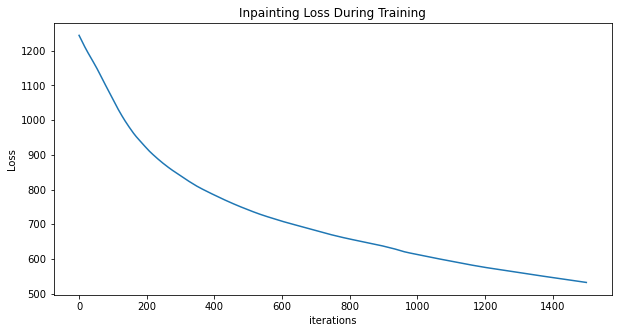

Starting Training for Batch 10...
Iteration No. = 500
Loss = tensor(744.2970, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1000
Loss = tensor(617.3607, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1500
Loss = tensor(542.4481, device='cuda:0', grad_fn=<AddBackward0>)


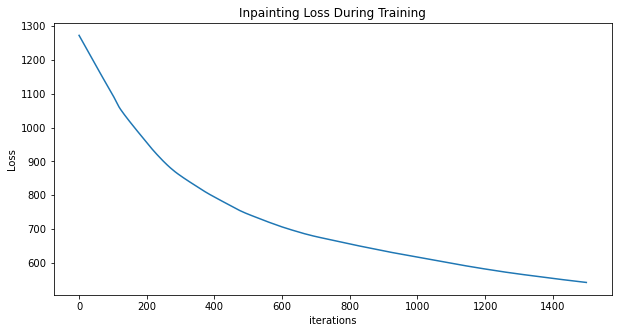

Starting Training for Batch 20...
Iteration No. = 500
Loss = tensor(693.4161, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1000
Loss = tensor(579.7076, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1500
Loss = tensor(514.9018, device='cuda:0', grad_fn=<AddBackward0>)


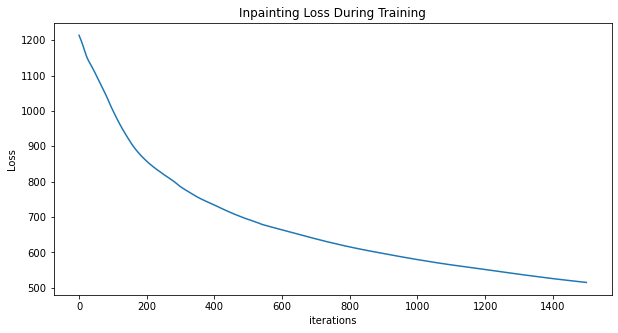

Starting Training for Batch 30...
Iteration No. = 500
Loss = tensor(689.9193, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1000
Loss = tensor(564.4756, device='cuda:0', grad_fn=<AddBackward0>)
Iteration No. = 1500
Loss = tensor(485.4863, device='cuda:0', grad_fn=<AddBackward0>)


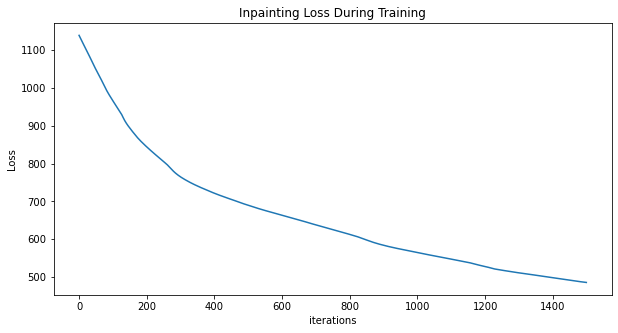

In [13]:
for i, (images, masks) in enumerate(test_loader_pattern):
  losses = []
  images = images.to(device)
  masks = masks.to(device)
  Z = random_z(batch_size=16)
  optimizer = optim.Adam([Z])
  if (i+1)%10==0 or i==0:
    print("Starting Training for Batch "+str(i+1)+"...")
  for iter in range(1500):
    outputs = Generator(Z)
    discriminator_outputs = Discriminator(outputs)
    closs = context_loss(outputs,images,masks,window_size=7)
    ploss = prior_loss(discriminator_outputs,Lambda=0.003)
    inpainting_loss = closs + ploss
    optimizer.zero_grad()
    inpainting_loss.backward()
    optimizer.step()
    losses.append(inpainting_loss)
    if (i+1)%10==0 or i==0:
      if (iter+1)%500==0:
        print("Iteration No. = "+str(iter+1))
        print("Loss = "+str(inpainting_loss))
  if (i+1)%10==0 or i==0:
    plt.figure(figsize=(10,5))
    plt.title("Inpainting Loss During Training")
    plt.plot(losses)
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.show()
  Z_optimal = Z.detach()
  generated_images = Generator(Z_optimal)
  generated_images = generated_images.detach().cpu().numpy()
  generated_images = np.transpose(generated_images,(0,2,3,1))
  generated_images = ((generated_images+1.)/2.)*255.
  generated_images = generated_images.astype(np.uint8)
  images_for_blend = images.detach().cpu().numpy()
  images_for_blend = np.transpose(images_for_blend,(0,2,3,1))
  images_for_blend = ((images_for_blend+1.)/2.)*255.
  images_for_blend = images_for_blend.astype(np.uint8)
  masks_for_blend = (1.-masks).detach().cpu().numpy()
  masks_for_blend = (masks_for_blend*255.).astype(np.uint8)
  masks.unsqueeze_(1)
  masks = torch.cat((masks,masks,masks),dim=1)
  temp_mask = masks.detach().cpu().numpy().astype(np.uint8)
  temp_mask = np.transpose(temp_mask,(0,2,3,1))
  for j in range(generated_images.shape[0]):
    masked_image = images_for_blend[j,:,:,:]*temp_mask[j,:,:,:]
    original_image = Image.fromarray(np.uint8(images_for_blend[j,:,:,:]))
    masked_image = Image.fromarray(np.uint8(masked_image)) 
    #original_image.save("{}_Original_Image".format(1+(i*generated_images.shape[0])+j),"PNG")
    masked_image.save("{}_Pattern_Masked_Image.png".format(1+(i*generated_images.shape[0])+j),"PNG")
    inpainting_result = blend(images_for_blend[j,:,:,:],generated_images[j,:,:,:],masks_for_blend[j,:,:],offset=(0,0))
    #inpainting_result = (1-temp_mask[j,:,:,:])*generated_images[j,:,:,:] + (temp_mask[j,:,:,:])*images_for_blend[j,:,:,:]
    inpainted_image = Image.fromarray(np.uint8(inpainting_result))
    inpainted_image.save("{}_Pattern_Inpainted_Image.png".format(1+(i*generated_images.shape[0])+j),"PNG")